## 权重衰减

权重衰减（weight decay)通常用来应对**过拟合**，等价于$L_2$范数正则化（regularization）：通过将loss function添加惩罚项抑制学习出来的模型参数。以线性回归为例：

$$
Loss = \ell (\omega_1,\omega_2,b) + \frac{\lambda}{2n}\|\mathbf{\omega}\|^2
$$

在小批量随机梯度下降中，参数的迭代方式修改为：

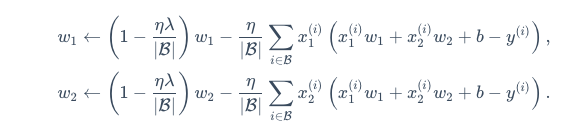

In [1]:
import torch
import torch.nn as nn
import numpy as np
import sys

In [2]:
import io, os, sys, types
from IPython import get_ipython
from nbformat import read
from IPython.core.interactiveshell import InteractiveShell
def find_notebook(fullname, path=None):
    """find a notebook, given its fully qualified name and an optional path
    
    This turns "foo.bar" into "foo/bar.ipynb"
    and tries turning "Foo_Bar" into "Foo Bar" if Foo_Bar
    does not exist.
    """
    name = fullname.rsplit('.', 1)[-1]
    if not path:
        path = ['']
    for d in path:
        nb_path = os.path.join(d, name + ".ipynb")
        if os.path.isfile(nb_path):
            return nb_path
        # let import Notebook_Name find "Notebook Name.ipynb"
        nb_path = nb_path.replace("_", " ")
        if os.path.isfile(nb_path):
            return nb_path
        
class NotebookLoader(object):
    """Module Loader for Jupyter Notebooks"""
    def __init__(self, path=None):
        self.shell = InteractiveShell.instance()
        self.path = path
    
    def load_module(self, fullname):
        """import a notebook as a module"""
        path = find_notebook(fullname, self.path)
        
        print ("importing Jupyter notebook from %s" % path)
                                       
        # load the notebook object
        with io.open(path, 'r', encoding='utf-8') as f:
            nb = read(f, 4)
        
        
        # create the module and add it to sys.modules
        # if name in sys.modules:
        #    return sys.modules[name]
        mod = types.ModuleType(fullname)
        mod.__file__ = path
        mod.__loader__ = self
        mod.__dict__['get_ipython'] = get_ipython
        sys.modules[fullname] = mod
        
        # extra work to ensure that magics that would affect the user_ns
        # actually affect the notebook module's ns
        save_user_ns = self.shell.user_ns
        self.shell.user_ns = mod.__dict__
        
        try:
          for cell in nb.cells:
            if cell.cell_type == 'code':
                # transform the input to executable Python
                code = self.shell.input_transformer_manager.transform_cell(cell.source)
                # run the code in themodule
                exec(code, mod.__dict__)
        finally:
            self.shell.user_ns = save_user_ns
        return mod
class NotebookFinder(object):
    """Module finder that locates Jupyter Notebooks"""
    def __init__(self):
        self.loaders = {}
    
    def find_module(self, fullname, path=None):
        nb_path = find_notebook(fullname, path)
        if not nb_path:
            return
        
        key = path
        if path:
            # lists aren't hashable
            key = os.path.sep.join(path)
        
        if key not in self.loaders:
            self.loaders[key] = NotebookLoader(path)
        return self.loaders[key]

sys.meta_path.append(NotebookFinder())

In [26]:
import dl_pytorch_1 as d2l

### 高维线性回归实验

In [4]:
n_train,n_test,inputs=20,100,200#训练样本数20模拟过拟合

In [5]:
t_w,t_b = torch.ones(inputs,1)*0.01,0.05

In [6]:
features=torch.randn(n_train+n_test,inputs)
labels = torch.matmul(features,t_w)+t_b

In [7]:
labels+=torch.tensor(np.random.normal(0,0.01,size=labels.size()),dtype=torch.float)
t_features,test_features = features[:n_train,:],features[n_train:,:]
t_labels , test_labels = labels[:n_train],labels[n_train:]

In [8]:
def init_params():
    w=torch.randn((inputs,1),requires_grad=True)
    b=torch.zeros(1,requires_grad=True)
    return [w,b]

In [10]:
def l2_penalty(w):
    return (w**2).sum()/2#没有乘以lambda除以n

In [11]:
batch ,epochs,lr=1,100,0.003

In [12]:
net,loss=d2l.linreg,d2l.squared_loss

In [15]:
dataset = torch.utils.data.TensorDataset(t_features,t_labels)
train_iter = torch.utils.data.DataLoader(dataset,batch,shuffle=True)

In [23]:
import d2l as dl

In [32]:
def fit_and_plot(lambda_):
    w,b=init_params()
    train_loss,test_loss=[],[]
    for _ in range(epochs):
        #每个epoch
        for X,y in train_iter:
            #每个批次
            l = loss(net(X,w,b),y)+lambda_*l2_penalty(w)/batch
            l=l.sum()
            
            if w.grad is not None:
                w.grad.data.zero_()
                b.grad.data.zero_()
            l.backward()
            d2l.sgd([w,b],lr,batch)
        
        train_loss.append(loss(net(t_features,w,b),t_labels).mean().item())
        test_loss.append(loss(net(test_features,w,b),test_labels).mean().item())
    dl.semilogy(range(1,epochs+1),train_loss,'epochs','loss',
                range(1,epochs+1),test_loss,["train","test"])
    print("w的L2范数是：",w.norm().item())

w的L2范数是： 12.64540958404541


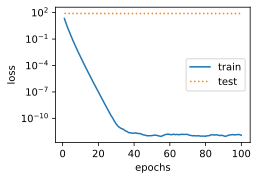

In [33]:
fit_and_plot(0)#过拟合

w的L2范数是： 0.03680076450109482


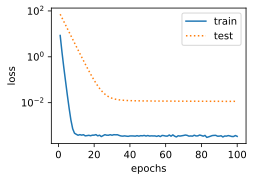

In [34]:
fit_and_plot(3)#使用权重衰减

## 简洁实现

In [39]:
def easy_fit_and_plot(wd):#wd权重衰减的lambda
        # 对权重参数衰减。权重名称一般是以weight结尾
    net = nn.Linear(inputs, 1)
    nn.init.normal_(net.weight, mean=0, std=1)
    nn.init.normal_(net.bias, mean=0, std=1)
    optimizer_w = torch.optim.SGD(params=[net.weight], lr=lr, weight_decay=wd) # 对权重参数衰减
    optimizer_b = torch.optim.SGD(params=[net.bias], lr=lr)  # 不对偏差参数衰减

    train_loss, test_loss = [], []
    for _ in range(epochs):
        for X, y in train_iter:
            l = loss(net(X), y).mean()
            optimizer_w.zero_grad()
            optimizer_b.zero_grad()

            l.backward()

            # 对两个optimizer实例分别调用step函数，从而分别更新权重和偏差
            optimizer_w.step()
            optimizer_b.step()
        train_loss.append(loss(net(t_features), t_labels).mean().item())
        test_loss.append(loss(net(test_features), test_labels).mean().item())
    dl.semilogy(range(1, epochs + 1), train_loss, 'epochs', 'loss',
                 range(1, epochs + 1), test_loss, ['train', 'test'])
    print('L2 norm of w:', net.weight.data.norm().item())

L2 norm of w: 13.526490211486816


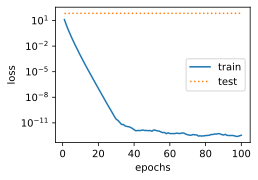

In [40]:
easy_fit_and_plot(0)

L2 norm of w: 0.03682268038392067


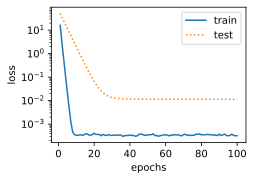

In [41]:
easy_fit_and_plot(3)